##### Copyright 2018 The TensorFlow Authors.


In [112]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


In [113]:
'''
Version Notes:
V14. Have valid loss, use B3 with 15 epochs 
V10. B5 w/ Noisy-Student weights 25 epochs -- pretty good on valid set, but not on test set (flickr)
V9. B5 w/ Noisy-Student weights 20 epochs
V8. B5 w/ imagenet weights
V6. InceptionV3 w/ imagenet weights
'''

## Try efficientnet in addition to InceptionV3 of the original example.
# !pip install -q tensorflow==2.2-rc1 # fix TPU memory issue
!pip install -q efficientnet




[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Image captioning with visual attention

Note that almost explanations and codes are from https://www.tensorflow.org/tutorials/text/image_captioning . The author of the kernel just 

 - adjust some minor modification for suiting Kaggle kernel environment.
 - made a validation calculation
 - import and predict on Out-of-distribution Flickr test set
 
In the next kernel, I plan to break the limit of Kaggle by implementing my own DataGenerator which will allow : 
 - Use full dataset (100K instead of 10K, or 30K by using Flickr30K dataset, due to limit of KaggleDatasets network)
 - Use 5 captions for all images
 - Use pretrained word vectors (Here, we could not do that due to limited RAM)
 - Use TPU to remedy the slowness of online-image-loading DataGenerator --> but have to use Flickr30k instead of COCO-100k
 
Note that I will not go to Colab to increase RAM, since in Colab we will have other problems of downloading again all datasets

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. In the original Colab notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model. In Kaggle environment, we already haave COCO 2014 stored locally. So great! no download is needed, and time is saved. :D

Here, due to limitation of RAM and space, you will train a model on a relatively small amount of data—the first 10,000 captions  for about 6,000-7,000 images (because there are multiple captions per image in the dataset). In the original Colab example, we have a lot more free space, so we can do 30,000 captions.

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage import io
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tensorflow.keras.utils import to_categorical, plot_model
#plot_model(model, show_shapes=True)

In [2]:
import kaggledatasets
import efficientnet.tfkeras as efn 

I post TPU initializer here just in case, but I have not yet successfully make it work on this example. Below code works for both TPU and GPU.

In [3]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


## Download and prepare the MS-COCO dataset [Colab only]

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. Originally, the dataset contains over 82,000 images, each of which has at least 5 different caption annotations. 

**Note: **. In Kaggle, we don't need to download, we can use existing dataset. Therefore, I comment out the code below which downloading and extracting the dataset automatically.

In [4]:
annotation_file = 'annotations/captions_train2014.json'
PATH = 'train2014/'
!ls {PATH} | wc

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [118]:
# # Download caption annotation files
# annotation_folder = '/annotations/'
# if not os.path.exists(os.path.abspath('.') + annotation_folder):
#   annotation_zip = tf.keras.utils.get_file('captions.zip',
#                                           cache_subdir=os.path.abspath('.'),
#                                           origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
#                                           extract = True)
#   annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
#   os.remove(annotation_zip)

# # Download image files
# image_folder = '/train2014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('train2014.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin = 'http://images.cocodataset.org/zips/train2014.zip',
#                                       extract = True)
#   PATH = os.path.dirname(image_zip) + image_folder
#   os.remove(image_zip)
# else:
#   PATH = os.path.abspath('.') + image_folder

In [5]:
%%time

if strategy.num_replicas_in_sync == 8:
#     GCS_DS_PATH_FLICKR = KaggleDatasets().get_gcs_path('flickr8k-sau') # 2gb # Less than 5 min
    GCS_DS_PATH = KaggleDatasets().get_gcs_path('coco2014') # 19gb # 20 min ?
    print('yeah')

CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
if strategy.num_replicas_in_sync == 8:
    # print(GCS_DS_PATH_FLICKR)
    # !gsutil ls $GCS_DS_PATH_FLICKR

    print(GCS_DS_PATH)
    !gsutil ls $GCS_DS_PATH

## Optional: limit the size of the training set 
To speed up training for this tutorial and due to memory-space limitation, you'll use a subset of 10,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality. We cannot do this in Kaggle environment, but you can do it locally.

In [7]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 10000 captions from the shuffled set
num_examples = 10000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [8]:
len(train_captions), len(all_captions)

(10000, 414113)

## Preprocess the images using EfficientNet / InceptionV3
Next, you will use either EfficientNet or InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3. EfficienetNet also has its own preprocessing_input function as shown in the code.

In [9]:
target_size = (299, 299,3)
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (target_size[0],target_size[1])) 
    
    # choose the suitable preprocessing for CNN
    img = tf.keras.applications.inception_v3.preprocess_input(img) 
    #img = efn.preprocess_input(img)
    
    return img, image_path

## Initialize CNN and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the CNN architecture. The shape of the output of this layer is ```8x8x2048``` for InceptionV3 or ```10x10x1280``` for EfficientNetB1 (or other shapes if using other-Bs). You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.


In [10]:
# with strategy.scope():
# image_model = tf.keras.applications.InceptionV3(include_top=False,
#                                                 weights='imagenet')

image_model = efn.EfficientNetB3(
        weights='noisy-student', # Choose between imagenet and 'noisy-student'
#         weights='imagenet', 
        input_shape=target_size, include_top=False)

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [11]:
# image_model.summary()
image_model.layers[-1], image_model.layers[-1].output.shape # see the information of the CNN output

(<keras.layers.core.activation.Activation at 0x2a0220b16d0>,
 TensorShape([None, 10, 10, 1536]))

In [12]:
image_model.summary()

Model: "efficientnet-b3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 150, 150, 40  1080        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 150, 150, 40  160         ['stem_conv[0][0]']              
                                )                                                   

In [127]:

#plot_model(image_model, show_shapes=True)

## Caching the features extracted from CNN

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 (or 10 \* 10 \* 1280 for B1, 10 \* 10 \* 2048 for B5 etc.) floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.


In [14]:
from tqdm import tqdm_notebook as tqdm
# Get unique images
encode_train = sorted(set(img_name_vector))

feature_dict = {}

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    feature_dict[path_of_feature] =  bf.numpy()

C:\Users\utkar\AppData\Local\Temp\ipykernel_16156\3125938404.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img, path in tqdm(image_dataset):


  0%|          | 0/598 [00:00<?, ?it/s]

In [15]:
import gc
gc.collect()
len(feature_dict)

9557

# Load Pretrained Word Vectors
Unfortunately, we don't have enough RAM ... See preface

In [16]:
from gensim.models import KeyedVectors
def build_matrix(word_index, embedding_index, vec_dim):
    emb_mean, emb_std = -0.0033470048, 0.109855264
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len(word_index) + 1,vec_dim))
#     embedding_matrix = np.zeros((len(word_index) + 1, vec_dim))
    for word, i in word_index.items():
        for candidate in [word, word.lower(), word.upper(), word.capitalize(), 
                          ps.stem(word), lc.stem(word), sb.stem(word), correction(word) ]:
            if candidate in embedding_index:
                embedding_matrix[i] = embedding_index[candidate]
                break
    return embedding_matrix

In [ ]:
# EMBEDDING_FILES = [
#     'gensim-embeddings-dataset/crawl-300d-2M.gensim',
#     'gensim-embeddings-dataset/glove.840B.300d.gensim'
# ]
# spell_model = gensim.models.KeyedVectors.load(EMBEDDING_FILES[0], mmap='r')

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [17]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [18]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [19]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [20]:
# make list from dict
tokenizer.index2word = [tokenizer.index_word[ii] for ii in range(len(tokenizer.word_index)) ] 
tokenizer.index2word[:20] # see top-20 most frequent words

['<pad>',
 '<unk>',
 'a',
 '<start>',
 '<end>',
 'on',
 'of',
 'the',
 'in',
 'with',
 'and',
 'is',
 'man',
 'to',
 'an',
 'sitting',
 'two',
 'standing',
 'people',
 'are']

In [21]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [22]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [23]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [24]:
lenx = np.array([len(x) for x in cap_vector])
print(lenx.min(), lenx.mean())

49 49.0


## Split the data into training and testing

In [25]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [26]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(8000, 8000, 2000, 2000)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [27]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048


In [28]:
attention_features_shape = bf.shape[0] # 64 for InceptionV3, 100 for B1
attention_features_shape


100

In [29]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = feature_dict[img_name.decode('utf-8')] # np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [30]:
img_name_train[:5]

['train2014/COCO_train2014_000000102739.jpg',
 'train2014/COCO_train2014_000000530486.jpg',
 'train2014/COCO_train2014_000000127304.jpg',
 'train2014/COCO_train2014_000000527858.jpg',
 'train2014/COCO_train2014_000000115400.jpg']

In [31]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [32]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# No Shuffle for Val and batch
# val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [33]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [34]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [35]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [36]:
# with strategy.scope():
# tf.keras.backend.clear_session()
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [38]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [39]:
start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   # restoring the latest checkpoint in checkpoint_path
#   ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [40]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [41]:
@tf.function # Non-teacher-forcing val_loss is too complicated at the moment
def val_step(img_tensor, target, teacher_forcing=True):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
#   print(dec_input.shape) # (BATCH_SIZE, 1)
  features = encoder(img_tensor)
#   print(features.shape) # (BATCH_SIZE, IMG_FEAT_LEN, ENCODER_HID) = 64 100 256
  for i in range(1, target.shape[1]):
    predictions, hidden, _ = decoder(dec_input, features, hidden)
    loss += loss_function(target[:, i], predictions)

    # using teacher forcing
    dec_input = tf.expand_dims(target[:, i], 1)

  avg_loss = (loss / int(target.shape[1]))
  return loss, avg_loss

def cal_val_loss(val_dataset):
  # target.shape = (64,49) = (BATCH_SIZE, SEQ_LEN)
  val_num_steps = len(img_name_val) // BATCH_SIZE

  total_loss = 0
  for (batch, (img_tensor, target)) in enumerate(val_dataset):
    batch_loss, t_loss = val_step(img_tensor, target)
    
    total_loss += t_loss
  print ('Valid Loss {:.6f}'.format(total_loss/val_num_steps))
  return total_loss/val_num_steps

In [42]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
val_loss_plot = []
gc.collect()

0

In [43]:
EPOCHS = 10
best_val_loss = 100
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

    loss_plot.append(total_loss / num_steps)    
    val_loss = cal_val_loss(val_dataset)
    val_loss_plot.append(val_loss)
    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if val_loss < best_val_loss:
      print('update best val loss from %.4f to %.4f' % (best_val_loss, val_loss))
      best_val_loss = val_loss
      ckpt_manager.save()

    

C:\Users\utkar\AppData\Local\Temp\ipykernel_16156\3835062821.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(start_epoch, EPOCHS)):


  0%|          | 0/10 [00:00<?, ?it/s]

Valid Loss 1.033910
Epoch 1 Loss 1.207963
Time taken for 1 epoch 844.2097549438477 sec

update best val loss from 100.0000 to 1.0339
Valid Loss 0.952368
Epoch 2 Loss 0.929384
Time taken for 1 epoch 712.7842185497284 sec

update best val loss from 1.0339 to 0.9524
Valid Loss 0.919385
Epoch 3 Loss 0.835323
Time taken for 1 epoch 710.6241183280945 sec

update best val loss from 0.9524 to 0.9194
Valid Loss 0.907200
Epoch 4 Loss 0.770557
Time taken for 1 epoch 725.6333630084991 sec

update best val loss from 0.9194 to 0.9072
Valid Loss 0.912493
Epoch 5 Loss 0.715966
Time taken for 1 epoch 791.9693803787231 sec

Valid Loss 0.916670
Epoch 6 Loss 0.667752
Time taken for 1 epoch 774.3176436424255 sec

Valid Loss 0.925030
Epoch 7 Loss 0.622183
Time taken for 1 epoch 763.219185590744 sec

Valid Loss 0.940005
Epoch 8 Loss 0.578736
Time taken for 1 epoch 708.4003329277039 sec

Valid Loss 0.960080
Epoch 9 Loss 0.539054
Time taken for 1 epoch 706.3517637252808 sec

Valid Loss 0.988914
Epoch 10 Loss 0

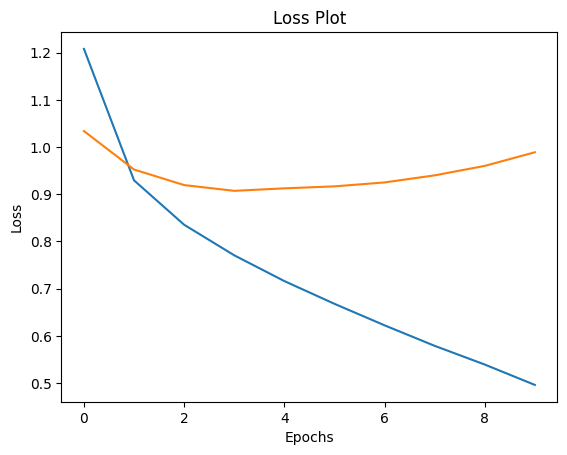

In [44]:
plt.plot(loss_plot)
plt.plot(val_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [45]:
encoder.save_weights('encoder.h5')
decoder.save_weights('decoder.h5')


In [ ]:
# usually val_loss is best too early and got poor result due to imperfect metric of word-by-word
# ckpt.restore(ckpt_manager.latest_checkpoint)
# cal_val_loss(val_dataset)

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [46]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    print(img_tensor_val.shape)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [47]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [48]:
def str2list(string):
    li = list(string.split(" "))
    return li

In [62]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.metrics import *


In [67]:
reference = 'DET NN VB DET JJ NN NN IN DET NN'.split()
test    = 'DET VB VB DET NN NN NN IN DET NN'.split()
print(accuracy(reference, test))

0.8


(1, 10, 10, 1536)
Real Caption: <start> a little girl feeding a carrot to a goat <end>
Prediction Caption: a young girl looks up to a goat <end>
BLEU: 0.533825
METEOR: 0.520833
Precision: 0.625000
Recall: 0.555556
F-measure: 0.588235


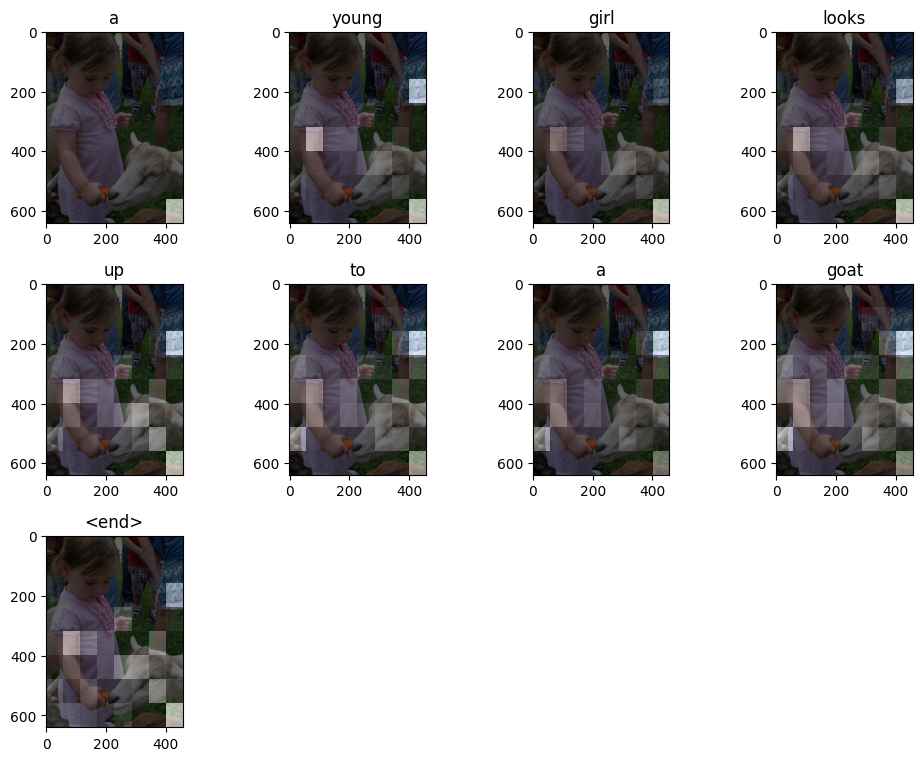

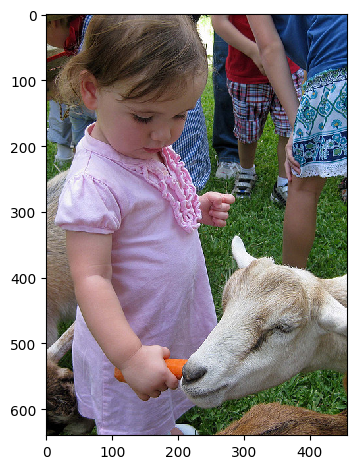

In [100]:
# captions on the train set

rid = np.random.randint(0, len(img_name_train))
image = img_name_train[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_train[rid] if i not in [0]])
result, attention_plot = evaluate(image)
rc=str2list(real_caption)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
print("BLEU: %f" % sentence_bleu([rc], result, weights = [1]))
print("METEOR: %f" % meteor_score([rc], result))
print("Precision: %f" % precision(set(rc), set(result)))
print("Recall: %f" % recall(set(rc), set(result)))
print("F-measure: %f" % f_measure(set(rc), set(result)))
plot_attention(image, result, attention_plot)
img2 = io.imread(image)
io.imshow(img2)



Caption: <start> a person under a parasail soars over a small lake <end>
Prediction Caption: a snowboarder practicing his board performing in the snow <end>


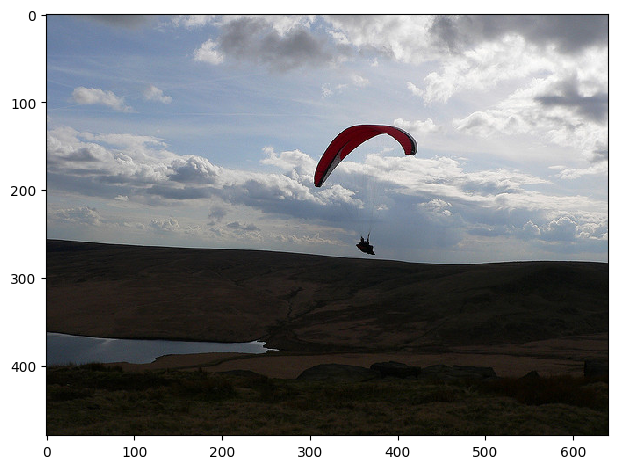

In [77]:
# captions on the validation set
for ii in range(1):
    rid = np.random.randint(0, len(img_name_val))
    image = img_name_val[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    #result, attention_plot = evaluate(image)
    img2 = io.imread(image)
    io.imshow(img2)
    print ('Caption:', real_caption)
    print ('Prediction Caption:', ' '.join(result))
    #plot_attention(image, result, attention_plot)


In [111]:

for ii in range(1):
    rid = np.random.randint(0, len(img_name_val))
    image = img_name_val[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(image)
    
    #print ('Real Caption:', real_caption)
    #print ('Prediction Caption:', ' '.join(result))
    #plot_attention(image, result, attention_plot)
    rc=str2list(real_caption)
    #print(rc)
    #print(result)
    print("BLEU-1: %f" % sentence_bleu([rc], result, weights = [1]))
    #print(sentence_bleu([rc], result, weights = [1]))

(1, 10, 10, 1536)
0.45454545454545453


In [78]:
# import gc
# del dataset
gc.collect()

217809

## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


In [ ]:
!ls ../input/flickr8k-sau/Flickr_Data/Images | head

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'

image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
flickr_path = '../input/flickr8k-sau/Flickr_Data/Images/'
paths2 = sorted(os.listdir(flickr_path))
print(len(paths2))

In [ ]:
# image_path2 ='../input/flickr8k-sau/Flickr_Data/Images/1000268201_693b08cb0e.jpg'
for ii in range(0,10):
    image_path2 = flickr_path + paths2[ii]
    result, attention_plot = evaluate(image_path2)
    print ('Prediction Caption:', ' '.join(result))
    plot_attention(image_path2, result, attention_plot)
    # opening the image
    Image.open(image_path2)

# Next steps

Congrats! You've just trained an image captioning model with attention.

In [ ]:
'''
Observations from kernel's author
=================================

0. InceptionV3 and B5 is better than B1, EfficientNet imagenet weights seem inferior to 'noisy-student' weights
1, poor performance on valid, especially for B1
2. poor attention visualization even on training data (focus wrong features)
3.[FIXED in V.12] cannot use best checkpoints based on val_loss 
4. cannot use model.fit directly

We cannot use model.fit directly on this implementation since each attention on a sequence requires 
a hidden state of the previous time-step

If we want implementation of Attention with model.fit, take a look at Andrew Ng's, see : 
https://github.com/Kulbear/deep-learning-coursera/blob/master/Sequence%20Models/Neural%20machine%20translation%20with%20attention%20-%20v2.ipynb

So in this case, all Keras.Callbacks can become handy together with model.fit
'''

'''
Future works, in order to futher improve the performance, we can 

A. word2vec instead of random embedding
OR
B. finetuning GPT-2 as decoder (Huggingface's implementation)

C.1 Use all captions
C.2 more training data ... either Flickr 30K or COCO ... Use DataGenerator to mitigate space problem (although make the process slower)

D. Removing stopping/stemming words (though we will have a bit worse grammar)

E. use SOTA sampling .. See HuggingFace blog

F. selecting best checkpoint based on BLEU score : see https://www.kaggle.com/anunay999/image-captioning-using-vgg16

G. try to use TPU
'''